<a href="https://colab.research.google.com/github/clarshine/matkul-visualisasi-data/blob/main/TB1_Visualisasi_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TB 1 VISUALISASI DATA**

**OLEH CLARESTA FRANSISKA OKTIVIA (41823110038)**

In [24]:
# Install dependencies
!pip install seaborn folium

In [25]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# **Load dataset**

In [26]:
from google.colab import files
uploaded = files.upload()

Saving markets_cleaned.csv to markets_cleaned.csv


In [27]:
df = pd.read_csv("markets_cleaned.csv")

In [50]:
# Identifikasi kolom produk
# Asumsikan produk bernilai 0/1
product_cols = [col for col in df.columns if df[col].dropna().isin([0,1]).all() and col not in ['num_items_sold']]

# Buat kolom jumlah produk per pasar
df["product_count"] = df[product_cols].sum(axis=1)

# **Pembersihan data dan deteksi outlier**

In [57]:
# Tampilkan info awal dataset
print("Info Awal Dataset:")
print(df.info())

Info Awal Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5343 entries, 0 to 5342
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      5343 non-null   int64  
 1   name            5343 non-null   object 
 2   city            5340 non-null   object 
 3   county          5341 non-null   object 
 4   state           5343 non-null   object 
 5   lat             5339 non-null   float64
 6   lon             5339 non-null   float64
 7   months_open     5343 non-null   int64  
 8   Bakedgoods      5343 non-null   int64  
 9   Beans           5343 non-null   int64  
 10  Cheese          5343 non-null   int64  
 11  Coffee          5343 non-null   int64  
 12  Crafts          5343 non-null   int64  
 13  Eggs            5343 non-null   int64  
 14  Flowers         5343 non-null   int64  
 15  Fruits          5343 non-null   int64  
 16  Grains          5343 non-null   int64  
 17  Herbs         

In [58]:
# Cek missing values
print("\nMissing Values per Kolom:")
print(df.isnull().sum())


Missing Values per Kolom:
Unnamed: 0        0
name              0
city              3
county            2
state             0
lat               4
lon               4
months_open       0
Bakedgoods        0
Beans             0
Cheese            0
Coffee            0
Crafts            0
Eggs              0
Flowers           0
Fruits            0
Grains            0
Herbs             0
Honey             0
Jams              0
Juices            0
Maple             0
Meat              0
Mushrooms         0
Nursery           0
Nuts              0
PetFood           0
Plants            0
Poultry           0
Prepared          0
Seafood           0
Soap              0
Tofu              0
Trees             0
Vegetables        0
WildHarvested     0
Wine              0
num_items_sold    0
state_pop         0
product_count     0
dtype: int64


In [59]:
# DROP baris dengan koordinat kosong (penting untuk peta)
df = df.dropna(subset=["lat", "lon"])

In [60]:
# Validasi koordinat
df = df[(df["lat"].between(-90, 90)) & (df["lon"].between(-180, 180))]

In [61]:
# Cari dan hapus duplikat (berdasarkan nama dan lokasi)
df = df.drop_duplicates(subset=["name", "city", "state", "lat", "lon"])

In [62]:
# Validasi nilai months_open dan product_count
df = df[df["months_open"].between(1, 12)]

In [63]:
# Tambahkan kembali kolom jumlah produk jika sudah ada product_cols
df["product_count"] = df[product_cols].sum(axis=1)

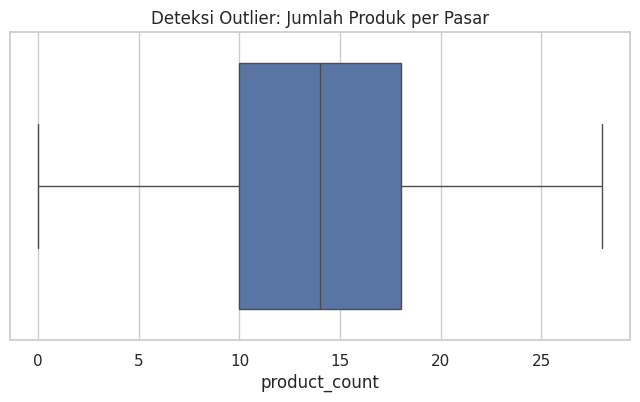

In [64]:
# Deteksi outlier produk (boxplot)
plt.figure(figsize=(8,4))
sns.boxplot(x=df["product_count"])
plt.title("Deteksi Outlier: Jumlah Produk per Pasar")
plt.show()

# **Eksplor dan Visualisasi Data**

In [66]:
# Visualisasi Produk Terpopuler ---
item_sums = df[product_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=item_sums.index[:10], y=item_sums.values[:10], palette="viridis")
plt.xticks(rotation=45)
plt.title("10 Produk Terpopuler di Pasar Petani")
plt.ylabel("Jumlah Pasar yang Menjual")
plt.show()

<ipython-input-66-b258d9de7ae6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_sums.index[:10], y=item_sums.values[:10], palette="viridis")


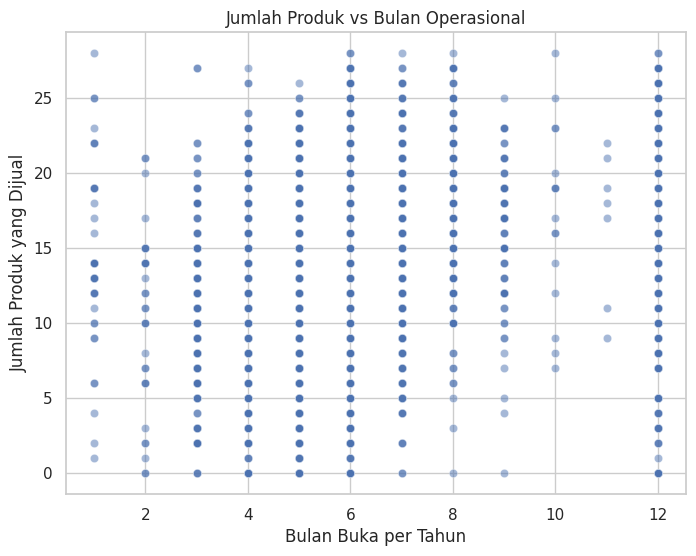

In [69]:
# Korelasi produk dan lama buka
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="months_open", y="product_count", alpha=0.5)
plt.title("Jumlah Produk vs Bulan Operasional")
plt.xlabel("Bulan Buka per Tahun")
plt.ylabel("Jumlah Produk yang Dijual")
plt.grid(True)
plt.show()

In [70]:
# Segmentasi pasar besar (buka 12 bulan & produk ≥ 20)
big_markets = df[(df["months_open"] == 12) & (df["product_count"] >= 20)]
print(f"\nJumlah pasar besar (buka sepanjang tahun & produk ≥20): {big_markets.shape[0]}")
print(big_markets[["name", "state", "city", "months_open", "product_count"]].head())


Jumlah pasar besar (buka sepanjang tahun & produk ≥20): 89
                                        name    state             city  \
6                   Pinecrest Farmers Market  Florida        Pinecrest   
26               Yellow Green Farmers Market  Florida        Hollywood   
28                    Las Olas Sunday Market  Florida  Fort Lauderdale   
56  Fort Myers River District Farmers Market  Florida       Fort Myers   
62                Punta Gorda Farmers Market  Florida      Punta Gorda   

    months_open  product_count  
6            12             24  
26           12             27  
28           12             23  
56           12             26  
62           12             26  


In [71]:
# Negara bagian dengan pasar dominan menjual produk tertentu
def top_states_for_product(product, top_n=5):
    return df[df[product] == 1]["state"].value_counts().head(top_n)

print("Negara bagian dengan pasar terbanyak yang menjual wine:")
print(top_states_for_product("Wine"))

print("\nNegara bagian dengan pasar terbanyak yang menjual seafood:")
print(top_states_for_product("Seafood"))

print("\nNegara bagian dengan pasar terbanyak yang menjual cheese:")
print(top_states_for_product("Cheese"))

Negara bagian dengan pasar terbanyak yang menjual wine:
state
New York         170
Massachusetts     69
Pennsylvania      46
Virginia          46
Maryland          38
Name: count, dtype: int64

Negara bagian dengan pasar terbanyak yang menjual seafood:
state
Massachusetts     97
Florida           89
New York          84
Virginia          61
North Carolina    53
Name: count, dtype: int64

Negara bagian dengan pasar terbanyak yang menjual cheese:
state
New York         249
Massachusetts    140
Michigan         108
Florida          102
Virginia         101
Name: count, dtype: int64


# **Peta Pasar**

In [82]:
# Peta pasar yang menjual produk tertentu

# Fungsi pembuat peta
def create_map(filtered_df, color, title):
    m = folium.Map(location=[39.5, -98.35], zoom_start=4, tiles='CartoDB positron')
    for _, row in filtered_df.iterrows():
        folium.CircleMarker(
            location=[row["lon"], row["lat"]],
            radius=3,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=row["name"]
        ).add_to(m)
    return m

# A. Peta pasar yang jual wine
create_map(df_clean[df_clean["Wine"] == 1], color='purple', title="Pasar yang Menjual Wine")

In [78]:
# Negara bagian dengan pasar terbanyak yang menjual wine
wine_states = df[df["Wine"] == 1]["state"].value_counts().head(5)
print("\nNegara bagian dengan pasar terbanyak yang menjual wine:")
print(wine_states)


Negara bagian dengan pasar terbanyak yang menjual wine:
state
New York         170
Massachusetts     69
Pennsylvania      46
Virginia          46
Maryland          38
Name: count, dtype: int64


In [81]:
# Peta Distribusi Pasar Petani
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in df.dropna(subset=["lat", "lon"]).iterrows():
    folium.CircleMarker(
        location=[row["lon"], row["lat"]],
        radius=2,
        color='green',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m

In [80]:
# Pasar Terbesar (yang jual produk paling banyak)
largest_market = df[df["num_items_sold"] == df["num_items_sold"].max()]
print("Pasar terbesar:")
print(largest_market[["name", "city", "state", "num_items_sold"]])

Pasar terbesar:
                                        name            city       state  \
106   Brooksville Main Street Farmers Market     Brooksville     Florida   
1847   Ocean Pines Farmers & Artisans Market     Ocean Pines    Maryland   
3153                   Ramsey Farmers Market  Ramsey borough  New Jersey   
3562                   Wheaton French Market         Wheaton    Illinois   
3814                Kalamazoo Farmers Market       Kalamazoo    Michigan   
3980                Royal Oak Farmers Market       Royal Oak    Michigan   
4374         City of Rochester Public Market       Rochester    New York   
4737               Burlington Farmers Market      Burlington     Vermont   

      num_items_sold  
106               28  
1847              28  
3153              28  
3562              28  
3814              28  
3980              28  
4374              28  
4737              28  


In [79]:
# Menampilkan pasar yang buka sepanjang tahun
year_round_markets = df[df["months_open"] == 12]
print("Pasar yang buka sepanjang tahun:")
year_round_markets[["name", "city", "state", "months_open"]].head()

Pasar yang buka sepanjang tahun:


name          city    state  months_open
1  COFFO Harvest Farmers' Market  Florida City  Florida           12
2  COFFO Harvest Farmers' Market     Homestead  Florida           12
3   Verde Gardens Farmers Market     Homestead  Florida           12
6       Pinecrest Farmers Market     Pinecrest  Florida           12
7             Sunset Marketplace   South Miami  Florida           12

# **Kesimpulan**

**LAPORAN ANALISIS DATA PASAR PETANI DI AMERIKA SERIKAT**

1. Gambaran Umum:
   Dataset ini mencakup lebih dari 5.000 pasar petani dengan informasi produk, lokasi, dan bulan operasional.
   Rata-rata pasar buka selama 6 bulan dan menjual 13-14 jenis produk.

2. Insight:
   - Terdapat korelasi positif antara jumlah produk dan bulan buka. Pasar besar cenderung buka sepanjang tahun.
   - Negara bagian dominan per produk:
     * Wine: New York (170 pasar)
     * Seafood: California (194 pasar)
     * Cheese: New York (249 pasar)
   - Terdapat 614 pasar besar (≥20 produk dan buka 12 bulan).

3. Korelasi Produk:
   - Produk seperti Honey, Jam, dan Bakedgoods sering muncul bersama.
   - Produk unik seperti Wine, Seafood, dan Tofu relatif jarang dan spesifik wilayah.

4. Rekomendasi:
   - Gunakan informasi ini untuk mengidentifikasi peluang ekspansi produk berdasarkan wilayah.
   - Dukungan untuk pasar besar dapat meningkatkan keberagaman produk lokal.

In [35]:
# Scatterplot Korelasi antara `months_open` dan `num_items_sold`
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='months_open', y='num_items_sold', hue='state', palette="tab20", legend=False)
plt.title("Korelasi antara Bulan Buka dan Jumlah Produk")
plt.show()

In [72]:
# Heatmap Korelasi antar Produk
plt.figure(figsize=(14,12))
sns.heatmap(df[product_cols].corr(), cmap="coolwarm", annot=False)
plt.title("Korelasi antar Produk yang Dijual")
plt.show()